In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [ ]:
def moving_average(data, window_size=15):
    X_smooth = np.zeros(data.shape)
    for i,channel in enumerate(data):
        X_smooth[i] = np.convolve(channel, np.ones(window_size)/window_size, mode='same')
    return torch.from_numpy(X_smooth).to(torch.float32)
def warp_time(data, label, max_scale=1.5):
    data = data.numpy()

    L = data.shape[1]
    scale = np.random.uniform(1, max_scale)
    new_L = int(L * scale)
    orig_t = np.linspace(0, 1, L)
    new_t = np.linspace(0, 1, new_L)

    warped = np.zeros((data.shape[0], new_L))
    for i, channel in enumerate(data):
        warped[i] = np.interp(new_t, orig_t, channel)
    
    label = torch.from_numpy(np.interp(new_t, orig_t, label)).to(torch.float32)
    # label = label * scale

    # randomly crop to original length
    if new_L > L:
        start_idx = np.random.randint(0, new_L - L)
        warped = warped[:, start_idx:start_idx + L]
        label = label[start_idx:start_idx + L]
        # label = label - (start_idx / L)

    return torch.from_numpy(warped).to(torch.float32), label

def scale(data, low=0.6, high=1.4):
    return data*np.random.uniform(low, high)

def segment_y(y, t=40):
    end_rep_markers = torch.where(torch.diff(y) < 0)[0]
    y = torch.zeros_like(y)
    starts = (end_rep_markers - t).clamp(0)
    ends = (end_rep_markers + t).clamp(0, y.shape[0])
    for start,end in zip(starts, ends):
        y[start: end] = 1
    return y
class IMUDataset(Dataset):
    def __init__(self, df, winsize=250, stride=50, transform=None, aug=False):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        self.y = torch.from_numpy(df['rir'].values).to(torch.float32)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.len = (self.X.shape[1] - winsize) // stride + 1
        self.aug = aug
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        start = i * self.stride
        end = start + self.winsize
        y = self.y[start:end]#.mean()

        # FOR REGRESSION: y = y.mean() (single value)
        # y = y.mean()

        # FOR BINARY: 1 if y is last rep (< 1.5), 0 if not (single value)
        # y = torch.Tensor([1.0 if y.mean() < 1.5 else 0.0])

        # FOR SEGMENTATION: if y changes during window, y = 1 at that point. everywhere else is 0 (<winsize> values)
        y = segment_y(y)

        # FOR SEGMENTATION REGRESSION: y = time when y changes (single value)
        # diff = torch.diff(y)
        # y = torch.diff(y).argmin().unsqueeze(0) / self.winsize if diff.min() < 0 else torch.Tensor([-1])
        
        X = self.X[:, start:end]
        X = moving_average(X)
        if self.aug:
            X,y = warp_time(X, y)
            X = scale(X)
        return X, y

In [11]:
HZ = 100
in_channels = 6
df = pd.read_csv('../data/data-strom.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

df[['acc_x', 'acc_y', 'acc_z']] = (df[['acc_x', 'acc_y', 'acc_z']] / 2.0).clip(-1, 1)           # normalize accelerometer data from [-2g, 2g] to [-1, 1]
df[['gyr_x', 'gyr_y', 'gyr_z']] = (df[['gyr_x', 'gyr_y', 'gyr_z']] / 250.0).clip(-1, 1)         # normalize gyroscope data from [-250dps, 250dps] to [-1, 1]

# winsize_t = 5 # seconds
# stride_t = 0.01 # seconds
# winsize = int(winsize_t * HZ)
# stride = int(stride_t * HZ)
winsize = 1024
stride = 2
print(winsize, stride)

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
# norm = torch.from_numpy(train.mean(axis=0)), torch.from_numpy(train.std(axis=0))

# def transform(x):
    # return (x - norm[0]) / norm[1]
transform = None

train_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform, aug=True) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform, aug=False) for session_id in val_ids])

len(train_dataset), len(val_dataset)

72
1024 2


(70866, 20585)

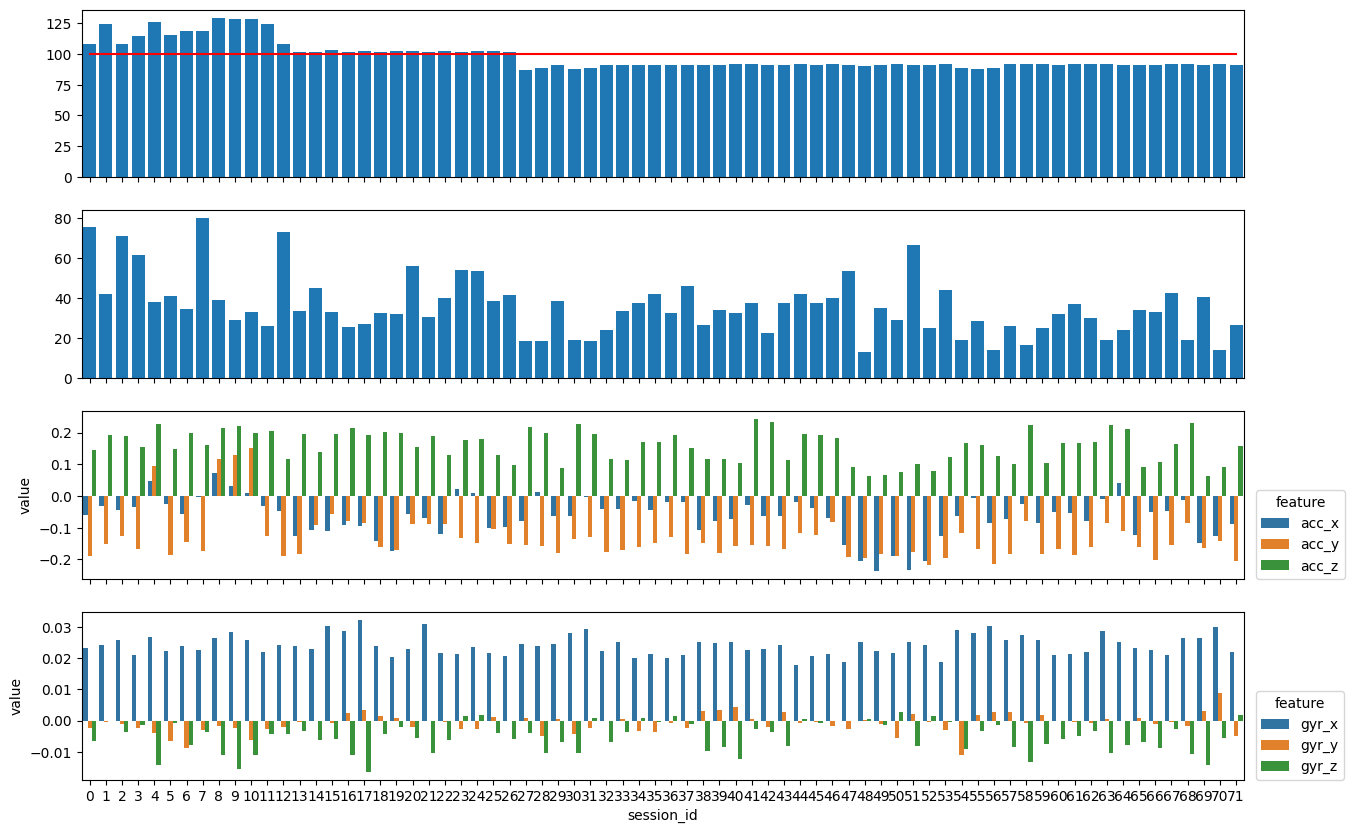

In [12]:
fig,axes = plt.subplots(4,1, sharex=True, figsize=(15,10))
hzs = np.array([(np.diff(df[df['session_id'] == session_id].time.values).mean().round(5)) for session_id in session_ids])
axes[0].bar(session_ids, 1 / hzs)
axes[0].plot(session_ids, np.ones(len(session_ids)) * 100, 'red')

axes[1].bar(session_ids, df.groupby('session_id').size().values / HZ)

means = df.groupby('session_id', as_index=False).mean(numeric_only=True)
acc_means = means.melt(id_vars='session_id', value_vars=['acc_x', 'acc_y', 'acc_z'], var_name='feature', value_name='value')
gyr_means = means.melt(id_vars='session_id', value_vars=['gyr_x', 'gyr_y', 'gyr_z'], var_name='feature', value_name='value')

sns.barplot(acc_means, x=acc_means['session_id'], y='value', hue='feature', ax=axes[2])
sns.move_legend(axes[2], loc=(1.01, 0))

sns.barplot(gyr_means, x=gyr_means['session_id'], y='value', hue='feature', ax=axes[3])
sns.move_legend(axes[3], loc=(1.01, 0))

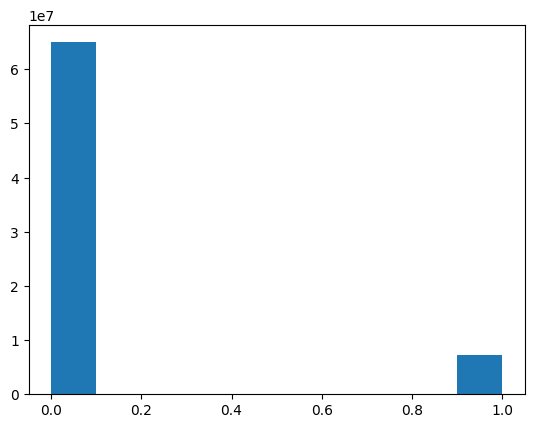

In [13]:
# windows = []
window_labels = []
for X, y in train_dataset:
    # windows.append(X.T.numpy())
    window_labels.append(y)
window_labels = np.array(window_labels).flatten()
plt.hist(window_labels);

In [14]:
(window_labels == 0).sum() / (window_labels == 1).sum()

np.float64(8.969757532481108)

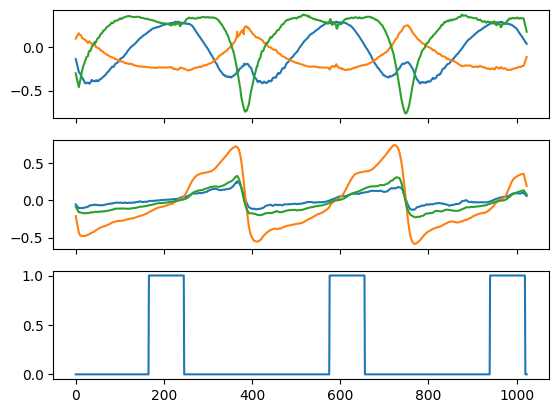

In [13]:
# X,y = train_dataset[0]
X,y = val_dataset[120]

fig, axes = plt.subplots(3,1, sharex=True)

axes[0].plot(X[0])
axes[0].plot(X[1])
axes[0].plot(X[2])

axes[1].plot(X[3])
axes[1].plot(X[4])
axes[1].plot(X[5])

# if y > 0:
#     vline = y * winsize
#     axes[0].axvline(vline, color='red', linestyle='--')
#     axes[1].axvline(vline, color='red', linestyle='--')

axes[2].plot(y)

# t = np.where(y == 1)[0]
# for ti in t:
#     axes[0].axvline(ti, color='red', linestyle='--')
#     axes[1].axvline(ti, color='red', linestyle='--')
# plt.suptitle(y.item())

In [4]:
class ResBlock(nn.Module):
    # One layer of convolutional block with batchnorm, relu and dropout
    def __init__(
            self, in_channels, out_channels,
            kernel_size=3, stride=1, dropout=0.0,
        ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 
                kernel_size=kernel_size, stride=stride, padding=kernel_size // 2,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.skip = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, stride=stride
        ) if in_channels != out_channels or stride > 1 else nn.Identity()
    def forward(self, x):
        return self.block(x) + self.skip(x)
    
class DepthBlock(nn.Module):
    # "depth" number of ConvBlocks with downsample on the first block
    def __init__(
            self, depth, in_channels, out_channels,
            kernel_size=3, downsample_stride=2, 
            dropout=0.0
    ):
        super().__init__()
        self.blocks = nn.Sequential(*[
            ResBlock(
                in_channels=in_channels if i == 0 else out_channels, 
                out_channels=out_channels,
                kernel_size=kernel_size, 
                stride=downsample_stride if i == 0 else 1,
                dropout=dropout
            )
            for i in range(depth)
        ])
    def forward(self, x):
        return self.blocks(x)
 
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.width = config['width']
        self.depth = config['depth']
        self.stem_out_c = config['stem_out_c']
        self.stem_kernel = config['stem_kernel']
        self.dropout = config['dropout']

        if len(self.width) != len(self.depth):
            raise ValueError('Width and depth must have the same length')
        self.conv_out_channels = self.stem_out_c if len(self.width) == 0 else self.width[-1]

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, self.stem_out_c, kernel_size=self.stem_kernel, padding=3),
            nn.BatchNorm1d(self.stem_out_c),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            *[DepthBlock(
                depth=self.depth[i],
                in_channels=self.stem_out_c if i == 0 else self.width[i-1], 
                out_channels=self.width[i],
                dropout=self.dropout, 
            ) for i in range(len(self.width))]
        )
    def forward(self, x):
        return self.encoder(x)

class ConvNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.encoder = Encoder(config)
        self.ap = nn.AdaptiveAvgPool1d(1)
        # self.fc = nn.Linear(512, winsize // 2)
        self.fc = nn.Linear(self.encoder.conv_out_channels, winsize)
    def forward(self, x):
        x = self.encoder(x)
        # x = self.conv(x)
        x = self.ap(x).squeeze(-1)
        x = self.fc(x)
        # x = torch.repeat_interleave(x, 2, dim=1)
        return x
    def freeze(self, stop_idx=None):
        if stop_idx is None:
            stop_idx = len(self.encoder.encoder)
        for block in self.encoder.encoder[:stop_idx]:
            for param in block.parameters():
                param.requires_grad = False
        # for param in self.encoder.parameters():
            # param.requires_grad = False

def iou_metric(ypred, y_true):
    if y_true.ndim != 2:
        raise ValueError
    intersection = (ypred * y_true).sum(axis=1)
    union = (ypred + y_true - ypred * y_true).sum(axis=1)
    iou = (intersection / union)
    iou[iou.isnan()] = 0.0
    return iou.mean()

class SegmentationLoss(nn.Module):
    def __init__(self, alpha, pos_weight, device):
        super().__init__()
        self.cat_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight])).to(device)
        self.reg_criterion = nn.MSELoss()
        # self.iou_criterion = iou_metric
        self.alpha = alpha
    def forward(self, ypred, y_true):
        probs = F.sigmoid(ypred)
        cat_loss = self.cat_criterion(ypred, y_true)
        reg_loss = self.reg_criterion(probs, y_true)
        # iou_loss = self.iou_criterion(probs.round(), y_true)

        # return 0.34*cat_loss + 0.33*reg_loss + 0.33*iou_loss
        return self.alpha*cat_loss + (1-self.alpha)*reg_loss

In [5]:
config = {
    'width': [64, 64, 64, 64, 128, 128, 256, 512, 1024],
    'depth': [1,  1,  1,   1,   1,   1,   1,   1,   1],
    'stem_out_c': 32,
    'stem_kernel': 7,
    'dropout': 0.0,
}

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
device = 'cuda'
model = ConvNet(config).to(device)
# model.freeze(-1)
# criterion = nn.MSELoss()
# criterion = Loss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([10])).to(device)
criterion = SegmentationLoss(0.8, 2, device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
print(sum(p.numel() for p in model.encoder.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2918816
3968416


In [106]:
state_dict = {'.'.join(k.split('.')[1:]):v for k,v in torch.load('best_model-pretrained.pth')[0].items() if k.startswith('encoder.')}
# state_dict = {'.'.join(k.split('.')[1:]):v for k,v in torch.load('best_model2.pth')[0].items() if k.startswith('encoder.')}

model.encoder.load_state_dict(state_dict)

<All keys matched successfully>

In [107]:
X,y = next(iter(trainloader))
ypred = model(X.to(device))
ypred.shape

torch.Size([128, 1024])

In [7]:
def train(epochs, model, trainloader, valloader, criterion, optimizer, outfile='best_model.pth'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            ypred = model(X)
            loss = criterion(ypred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trainloader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in valloader:
                X, y = X.to(device), y.to(device)
                ypred = model(X)
                loss = criterion(ypred, y)
                val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save((model.state_dict(),model.config), outfile)
            print(f'*Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}')
        else:
            print(f'Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}')
        torch.save((model.state_dict(),model.config), f'model.pth')
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Val')
        plt.legend()
        plt.savefig('loss.png')
        plt.close()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.legend()
    plt.show()
    return train_losses, val_losses

In [8]:
def evaluate(model, valloader, trainloader):
    model.eval()
    train_loss = 0
    train_iou = 0
    with torch.no_grad():
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            ypred = model(X)
            loss = criterion(ypred, y)
            train_loss += loss.item()
            train_iou += iou_metric(F.sigmoid(ypred).round(), y).item()
    train_loss /= len(trainloader)
    train_iou /= len(trainloader)
    print(f'Train Loss: {train_loss:.07f}\tTrain IOU: {train_iou:.07f}')

    val_loss = 0
    val_iou = 0
    ypreds = []
    ys = []
    with torch.no_grad():
        for X, y in valloader:
            X, y = X.to(device), y.to(device)
            ypred = model(X)
            loss = criterion(ypred, y)
            val_loss += loss.item()
            ypred = F.sigmoid(ypred).round()
            val_iou += iou_metric(ypred, y).item()
            ypreds.append(ypred.cpu())
            ys.append(y.cpu())
    ypreds = torch.cat(ypreds).numpy().flatten()
    ys = torch.cat(ys).numpy().flatten()

    val_loss /= len(valloader)
    val_iou /= len(valloader)
    print(f'Val Loss: {val_loss:.07f}\tVal IOU: {val_iou:.07f}')

    cm = confusion_matrix(ys, ypreds)
    tn, fp, fn, tp = cm.flatten()
    total = tn + fp + fn + tp

    labels = np.array([
        [f"{tn}\n{tn/total:.1%}", f"{fp}\n{fp/total:.1%}"],
        [f"{fn}\n{fn/total:.1%}", f"{tp}\n{tp/total:.1%}"]
    ])

    precision, recall, f1, _ = precision_recall_fscore_support(ys, ypreds, average='binary')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

*Epoch 0 train loss: 0.3285587617539634, val loss: 0.5052914125516134
Epoch 1 train loss: 0.16168516962133886, val loss: 0.5668497196891729
Epoch 2 train loss: 0.12119931724814861, val loss: 0.6358837300801978
Epoch 3 train loss: 0.10182289674368195, val loss: 0.7181094116147827
Epoch 4 train loss: 0.09155169540145099, val loss: 0.7215259921901366
Epoch 5 train loss: 0.08659687268586666, val loss: 0.7699778803569429
Epoch 6 train loss: 0.07982566284136174, val loss: 0.6887379854040987
Epoch 7 train loss: 0.07422526513612315, val loss: 0.7658184420098276
Epoch 8 train loss: 0.07071066599608374, val loss: 0.6396258839132155
Epoch 9 train loss: 0.06498079960847082, val loss: 0.7349045403301716
Epoch 10 train loss: 0.06398641747978477, val loss: 0.7250952055129934
Epoch 11 train loss: 0.06149681325392805, val loss: 0.7718968069728683
Epoch 12 train loss: 0.057663211676897655, val loss: 0.7686153406167732
Epoch 13 train loss: 0.05573086881790551, val loss: 0.7750691855654998
Epoch 14 train 

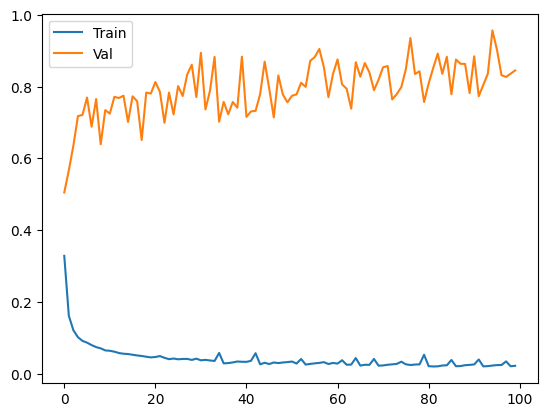

In [110]:
# TODO U-net
train_losses, val_losses = train(100, model, trainloader, valloader, criterion, optimizer, outfile='best_model-class.pth')

In [ ]:
# encoder - ap - fc: [2,2,2,1],32,[64,128,256,512]
# no pretrain, no freeze:               Epoch 0 train loss: 0.3585077467243481, val loss: 0.4568254962563515 then overfit
# no pretrain, freeze:                  Epoch 13 train loss: 0.6006816400094631, val loss: 0.7268715809373295 then stable
# no pretrain, freeze all but last:     Epoch 2 train loss: 0.394637428535708, val loss: 0.5571054241236518 then overfit some
# pretrain, no freeze:                  Epoch 0 train loss: 0.3285587617539634, val loss: 0.5052914125516134 then overfit
# pretrain, freeze:                     Epoch 6 train loss: 0.6034436684824215, val loss: 0.7165047940085916 then stable
# pretrain, freeze all but last:        Epoch 1 train loss: 0.375631075791533, val loss: 0.5646517803563791 then overfit some


Train Loss: 0.2348055	Train IOU: 0.6747632
Val Loss: 0.3704907	Val IOU: 0.5526682
Precision: 0.5731, Recall: 0.9520, F1: 0.7155


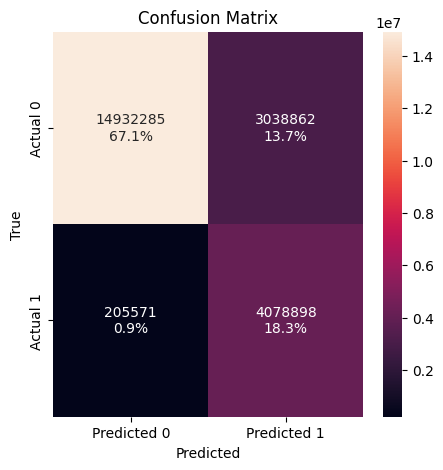

In [9]:
model.load_state_dict(torch.load('best_model-class.pth')[0])
# model.load_state_dict(torch.load('best_model-class.pth'))
evaluate(model, valloader, trainloader)

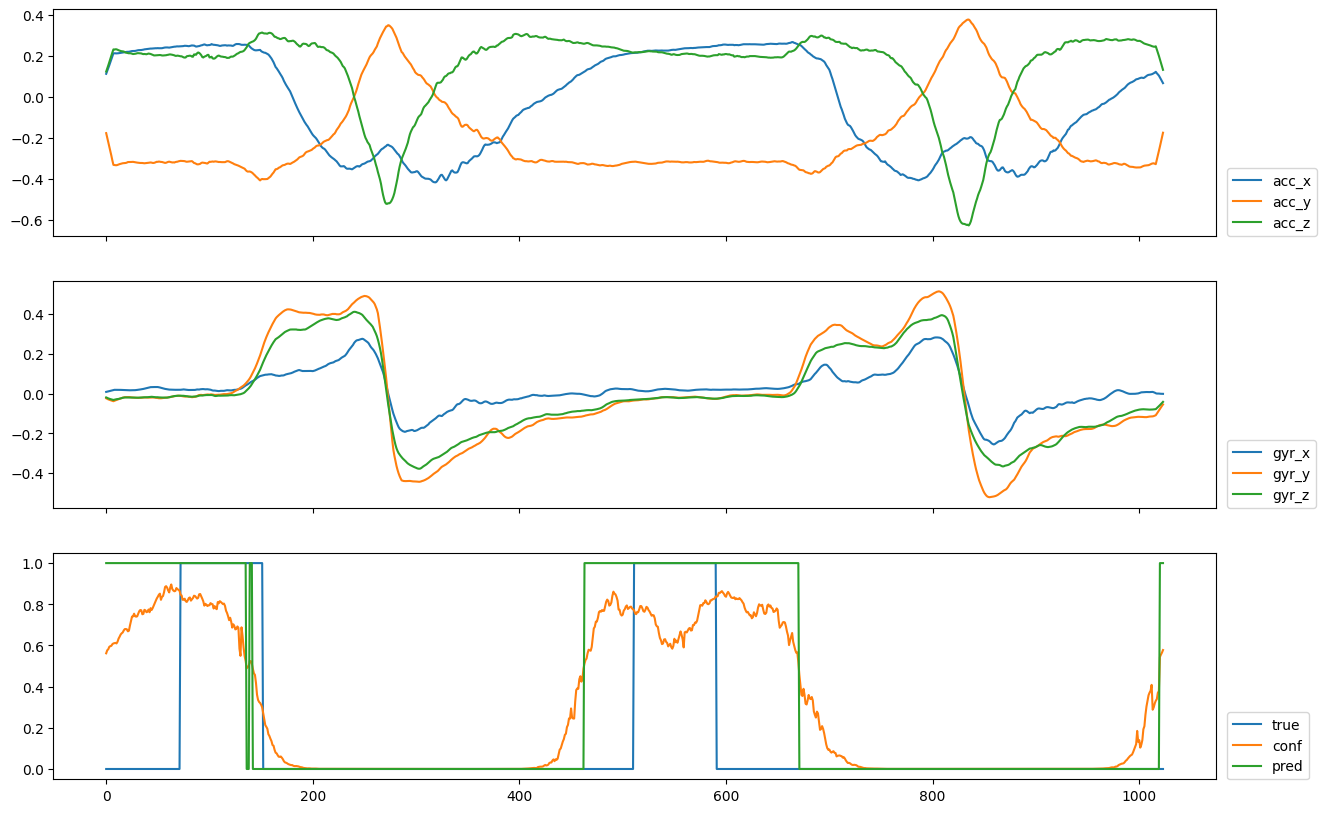

In [ ]:
#.819 shit
#.46 gets most - usually larger than true (false positives)
# 0.017, 0.07 perfect - (this was from overfit model on trainset)
X,y = valloader.dataset[2500]
X = X.unsqueeze(0)
y = y.unsqueeze(0)

model.eval()
# model.load_state_dict(torch.load('best_model-class.pth'))
model.load_state_dict(torch.load('best_model-class.pth')[0])

with torch.no_grad():
    ypred = model(X.to(device)).cpu()

i=0
fig, axes = plt.subplots(3,1, sharex=True, figsize=(15,10))
axes[0].plot(X[0,0].numpy(), label='acc_x')
axes[0].plot(X[0,1].numpy(), label='acc_y')
axes[0].plot(X[0,2].numpy(), label='acc_z')
axes[1].plot(X[0,3].numpy(), label='gyr_x')
axes[1].plot(X[0,4].numpy(), label='gyr_y')
axes[1].plot(X[0,5].numpy(), label='gyr_z')
axes[2].plot(y[0].numpy(), label='true')
axes[2].plot(F.sigmoid(ypred[0]).numpy(), label='conf')
axes[2].plot(F.sigmoid(ypred[0]).round().numpy(), label='pred')
axes[0].legend(loc=(1.01, 0))
axes[1].legend(loc=(1.01, 0))
axes[2].legend(loc=(1.01, 0))

In [62]:
X,y = next(iter(valloader))

model.eval()
model.load_state_dict(torch.load('best_model-class.pth'))

ypred = F.sigmoid(model(X.to(device))).round().cpu()

In [272]:
ys = []
ypreds = []
model.eval()
with torch.no_grad():
    for X, y in valloader:
        ypred = model(X).squeeze()
        ys.append(y)
        ypreds.append(ypred)
ys = torch.cat(ys)
ypreds = torch.cat(ypreds)

Text(0.5, 1.0, 'R^2: 0.03')

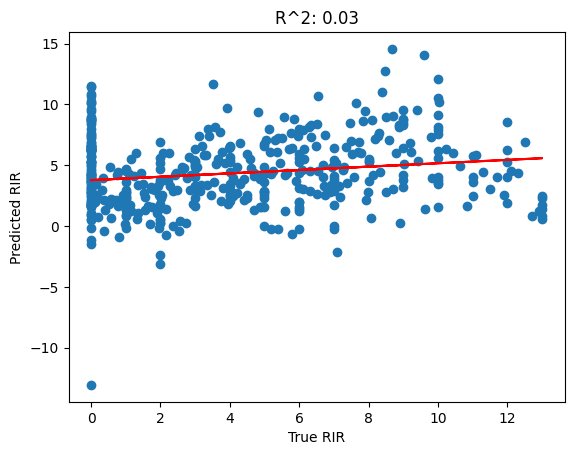

In [276]:
regr = linregress(ys, ypreds)
plt.scatter(ys, ypreds)
plt.plot(ys, regr.intercept + regr.slope * ys, color='red')
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')
plt.title(f'R^2: {regr.rvalue**2:.2f}')